## Load Data

In [1]:
import os
import re
import json
import math
import numpy as np
import scipy.stats as stats

workdir = './'

pathdata = os.path.join(workdir, 'data.json')
pathqrels = os.path.join(workdir, 'judgments.json')
pathtests = os.path.join(workdir, 'tests.json')

data = {}
qrels = {}
tests = {}

with open(pathdata, 'r', encoding='utf-8') as f:
    data = json.load(f)

with open(pathqrels, 'r', encoding='utf-8') as f:
    qrels = json.load(f)

with open(pathtests, 'r', encoding='utf-8') as f:
    tests = json.load(f)

## Query Measures

In [2]:
# number of queries
def numq(data, qrels, tests, sid):
    return [ len(data[sid]['searches']) ]

# unique number of queries
def numq_unique(data, qrels, tests, sid):
    return [ len(set([s['q'] for s in data[sid]['searches']])) ]

# number of queries w/o any clicks
def numq_noclick(data, qrels, tests, sid):
    return [ len([1 for s in data[sid]['searches'] if len([1 for r in s['results'] if len(r['click'])>0])>0]) ]

# number of characters per query
def qlen(data, qrels, tests, sid):
    return [ len(s['q']) for s in data[sid]['searches'] ]

# remove two consecutive duplicate queries
def removeDups(queries):
    nodups = []
    for query in queries:
        if len(nodups)==0 or query!=nodups[-1]:
            nodups.append(query)
    return nodups

def qsim(q1, q2, n):
    ngrams1 = set( [ q1[i:i+n] for i in range(len(q1)-n+1) ] )
    ngrams2 = set( [ q2[i:i+n] for i in range(len(q2)-n+1) ] )
    return len(ngrams1.intersection(ngrams2)) / len(ngrams1.union(ngrams2)) if len(ngrams1.union(ngrams2))>0 else np.nan

# unigram similarity between query pairs
def qsim_unigram(data, qrels, tests, sid):
    queries = removeDups( [ s['q'] for s in data[sid]['searches'] ] )
    return [ qsim(queries[i], queries[i+1], 1) for i in range(len(queries)-1) ]

# bigram similarity between query pairs
def qsim_bigram(data, qrels, tests, sid):
    queries = removeDups( [ s['q'] for s in data[sid]['searches'] ] )
    return [ qsim(queries[i], queries[i+1], 2) for i in range(len(queries)-1) ]

DVs_query = {
    'numq': numq,
    'numq_unique': numq_unique,
    'numq_noclick': numq_noclick,
    'qlen': qlen,
    'qsim_unigram': qsim_unigram,
    'qsim_bigram': qsim_bigram,
}

## Click Measures

In [3]:
# number of clicks
def numclicks(data, qrels, tests, sid):
    return [ np.sum( [ len(r['click']) for s in data[sid]['searches'] for r in s['results'] ] ) ]

# number of clicks by result category
def numclicks_misinfo(data, qrels, tests, sid):
    tqrel = qrels[data[sid]['task']]
    return [ np.sum( [ len(r['click']) for s in data[sid]['searches'] for r in s['results'] if tqrel[r['url']]=='misinfo' ] ) ]

# number of clicks by result category
def numclicks_correct(data, qrels, tests, sid):
    tqrel = qrels[data[sid]['task']]
    return [ np.sum( [ len(r['click']) for s in data[sid]['searches'] for r in s['results'] if tqrel[r['url']]=='correct' ] ) ]

# number of clicks by result category
def numclicks_nrel(data, qrels, tests, sid):
    tqrel = qrels[data[sid]['task']]
    return [ np.sum( [ len(r['click']) for s in data[sid]['searches'] for r in s['results'] if tqrel[r['url']]=='nrel' ] ) ]

# percentage of clicks by result category
def ratioclicks_misinfo(data, qrels, tests, sid):
    num = numclicks_misinfo(data, qrels, tests, sid)[0]
    total = numclicks(data, qrels, tests, sid)[0]
    return [ num/total ]

# percentage of clicks by result category
def ratioclicks_correct(data, qrels, tests, sid):
    num = numclicks_correct(data, qrels, tests, sid)[0]
    total = numclicks(data, qrels, tests, sid)[0]
    return [ num/total ]

# percentage of clicks by result category
def ratioclicks_nrel(data, qrels, tests, sid):
    num = numclicks_nrel(data, qrels, tests, sid)[0]
    total = numclicks(data, qrels, tests, sid)[0]
    return [ num/total ]

# percentage of displayed results by category
def ratioresults_misinfo(data, qrels, tests, sid):
    tqrel = qrels[data[sid]['task']]
    return [ np.sum( [ 1 for s in data[sid]['searches'] for r in s['results'] if tqrel[r['url']]=='misinfo' ] ) / np.sum( [ 1 for s in data[sid]['searches'] for r in s['results'] ] ) ]

# percentage of displayed results by category
def ratioresults_correct(data, qrels, tests, sid):
    tqrel = qrels[data[sid]['task']]
    return [ np.sum( [ 1 for s in data[sid]['searches'] for r in s['results'] if tqrel[r['url']]=='correct' ] ) / np.sum( [ 1 for s in data[sid]['searches'] for r in s['results'] ] ) ]

# percentage of displayed results by category
def ratioresults_nrel(data, qrels, tests, sid):
    tqrel = qrels[data[sid]['task']]
    return [ np.sum( [ 1 for s in data[sid]['searches'] for r in s['results'] if tqrel[r['url']]=='nrel' ] ) / np.sum( [ 1 for s in data[sid]['searches'] for r in s['results'] ] ) ]

# percentage of displayed results by category
def misinfo_density(data, qrels, tests, sid):
    tqrel = qrels[data[sid]['task']]
    num_misinfo = len([r for s in data[sid]['searches'] for r in s['results'] if tqrel[r['url']]=='misinfo'])
    num_correct = len([r for s in data[sid]['searches'] for r in s['results'] if tqrel[r['url']]=='correct'])
    density = 0 if num_misinfo+num_correct==0 else num_misinfo/(num_misinfo+num_correct)
    return [ density ]

# misinfo NDCG
def misinfo_ndcg(data, qrels, tests, sid):
    tqrel = qrels[data[sid]['task']]
    return [ rank_misinfo_ndcg(s['results'], tqrel) for s in data[sid]['searches'] ]

def rank_misinfo_ndcg(results, tqrel):
    sum_dcg = 0
    sum_idcg = 0
    for i in range(len(results)):
        discount = 1 / math.log2(i+2)
        rel_r = 1 if tqrel[results[i]['url']]=='misinfo' else 0
        rel_ir = 1
        sum_dcg += discount*(2**rel_r-1)
        sum_idcg += discount*(2**rel_ir-1)
    return sum_dcg/sum_idcg

DVs_click = {
    'numclicks': numclicks,
    'numclicks_misinfo': numclicks_misinfo,
    'numclicks_correct': numclicks_correct,
    'numclicks_nrel': numclicks_nrel,
    'ratioclicks_misinfo': ratioclicks_misinfo,
    'ratioclicks_correct': ratioclicks_correct,
    'ratioclicks_nrel': ratioclicks_nrel,
    'ratioresults_misinfo': ratioresults_misinfo,
    'ratioresults_correct': ratioresults_correct,
    'ratioresults_nrel': ratioresults_nrel,
    'misinfo_density': misinfo_density,
    'misinfo_ndcg': misinfo_ndcg
}

## Pre-task and Post-task Survey

In [4]:
def pre_familiar(data, qrels, tests, sid):
    return [ data[sid]['presurvey']['familiar'] ]

def pre_explore(data, qrels, tests, sid):
    return [ data[sid]['presurvey']['explore'] ]

def pre_interest(data, qrels, tests, sid):
    return [ data[sid]['presurvey']['interest'] ]

def pre_credible(data, qrels, tests, sid):
    return [ data[sid]['presurvey']['credible'] ]

def pre_expdiff(data, qrels, tests, sid):
    return [ data[sid]['presurvey']['expdiff'] ]

def pre_capable(data, qrels, tests, sid):
    return [ data[sid]['presurvey']['capable'] ]

def post_sufficient(data, qrels, tests, sid):
    return [ data[sid]['postsurvey']['sufficient'] ]

def post_explore(data, qrels, tests, sid):
    return [ data[sid]['postsurvey']['explore'] ]

def post_effort(data, qrels, tests, sid):
    return [ data[sid]['postsurvey']['effort'] ]

def post_useful(data, qrels, tests, sid):
    return [ data[sid]['postsurvey']['useful'] ]

def post_credible(data, qrels, tests, sid):
    return [ data[sid]['postsurvey']['credible'] ]

def post_confidence(data, qrels, tests, sid):
    return [ data[sid]['postsurvey']['confidence'] ]

DVs_survey = {
    'pre_familiar': pre_familiar,
    'pre_explore': pre_explore,
    'pre_interest': pre_interest,
    'pre_credible': pre_credible,
    'pre_expdiff': pre_expdiff,
    'pre_capable': pre_capable,
    'post_sufficient': post_sufficient,
    'post_explore': post_explore,
    'post_effort': post_effort,
    'post_useful': post_useful,
    'post_credible': post_credible,
    'post_confidence': post_confidence,
}

## Pre-task and Post-task Tests

In [5]:
pretest_answers = {}
for testid in [x+1 for x in range(20)]:
    pretest_answers[testid] = lambda data, qrels, tests, sid, testid=testid:[ data[sid]['pretest'][str(testid)] ]

posttest_answers = {}
for testid in [x+1 for x in range(20)]:
    posttest_answers[testid] = lambda data, qrels, tests, sid, testid=testid:[ data[sid]['posttest'][str(testid)] ]

deltatest_answers = {}
for testid in [x+1 for x in range(20)]:
    deltatest_answers[testid] = lambda data, qrels, tests, sid, testid=testid:[ data[sid]['posttest'][str(testid)] - data[sid]['pretest'][str(testid)] ]

def pre_correctness(data, qrels, tests, sid):
    correct = 0
    total = 0
    s = data[sid]
    for testid in s['pretest']:
        g = tests[s['task']][testid]['answer']
        u = s['pretest'][testid]
        total += 1
        if ( g==1 and u>3 ) or ( g==0 and u<3 ):
            correct += 1
    return [ correct/total ]

def post_correctness(data, qrels, tests, sid):
    correct = 0
    total = 0
    s = data[sid]
    for testid in s['posttest']:
        g = tests[s['task']][testid]['answer']
        u = s['posttest'][testid]
        total += 1
        if ( g==1 and u>3 ) or ( g==0 and u<3 ):
            correct += 1
    return [ correct/total ]

def diff_correctness(data, qrels, tests, sid):
    return [ post_correctness(data,qrels,tests,sid)[0] - pre_correctness(data,qrels,tests,sid)[0] ]

def pre_deviation(data, qrels, tests, sid):
    deviation = []
    s = data[sid]
    for testid in s['pretest']:
        g = 5 if tests[s['task']][testid]['answer']==1 else 1
        u = s['pretest'][testid]
        deviation.append(np.abs(u-g))
    return [np.mean(deviation)]

def post_deviation(data, qrels, tests, sid):
    deviation = []
    s = data[sid]
    for testid in s['posttest']:
        g = 5 if tests[s['task']][testid]['answer']==1 else 1
        u = s['posttest'][testid]
        deviation.append(np.abs(u-g))
    return [np.mean(deviation)]

def diff_deviation(data, qrels, tests, sid):
    return [ pre_deviation(data,qrels,tests,sid)[0] - post_deviation(data,qrels,tests,sid)[0] ]

DVs_test = {
    'pre_correctness': pre_correctness,
    'post_correctness': post_correctness,
    'diff_correctness': diff_correctness,
    'pre_deviation': pre_deviation,
    'post_deviation': post_deviation,
    'diff_deviation': diff_deviation
}

DVs_test_task1 = { 'pretest_answers_Q%d'%(x+1):pretest_answers[x+1] for x in range(10) }
DVs_test_task1.update( { 'posttest_answers_Q%d'%(x+1):posttest_answers[x+1] for x in range(10) } )
DVs_test_task1.update( { 'deltatest_answers_Q%d'%(x+1):deltatest_answers[x+1] for x in range(10) } )

DVs_test_task2 = { 'pretest_answers_Q%d'%(x+11):pretest_answers[x+11] for x in range(10) }
DVs_test_task2.update( { 'posttest_answers_Q%d'%(x+11):posttest_answers[x+11] for x in range(10) } )
DVs_test_task2.update( { 'deltatest_answers_Q%d'%(x+11):deltatest_answers[x+11] for x in range(10) } )

## ANOVA Tests

In [6]:
from scipy.stats import f_oneway

def getDVvalues( data, qrels, tests, DV, setting, tasks ):
    values = []
    for sid in data:
        s = data[sid]
        if s['setting']==setting and s['task'] in tasks:
            for v in DV(data, qrels, tests, sid):
                if not np.isnan(v):
                    values.append(v)
    return values

def star(pval):
    if pval<0.001:
        return '***'
    if pval<0.01:
        return '**'
    if pval<0.05:
        return '*'
    return ''


def anovaDVs( data, qrels, tests, DVs, tasks ):

    print(
        '%-40s%10s %7s%10s %7s%10s %7s      %s' % (
            'DV',
            'Low', '',
            'Med', '',
            'High', '',
            'p (ANOVA)'
        )
    )

    for DV in DVs:
        values_low = getDVvalues( data, qrels, tests, DVs[DV], 'Low', tasks )
        values_med = getDVvalues( data, qrels, tests, DVs[DV], 'Med', tasks )
        values_high = getDVvalues( data, qrels, tests, DVs[DV], 'High', tasks )
        mean_low = np.mean( values_low )
        mean_med = np.mean( values_med )
        mean_high = np.mean( values_high )
        sem_low = stats.sem( values_low )
        sem_med = stats.sem( values_med )
        sem_high = stats.sem( values_high )
        f, p = f_oneway( values_low, values_med, values_high )
        print(
            '%-40s%10.3f (%.3f)%10.3f (%.3f)%10.3f (%.3f)      p=%.4f %s' % (
                DV,
                mean_low, sem_low,
                mean_med, sem_med,
                mean_high, sem_high,
                p, star(p)
            )
        )


In [7]:
from scipy.stats import f_oneway

def anovaDVsLatex( data, qrels, tests, DVs, tasks ):

    for DV in DVs:
        values_low = getDVvalues( data, qrels, tests, DVs[DV], 'Low', tasks )
        values_med = getDVvalues( data, qrels, tests, DVs[DV], 'Med', tasks )
        values_high = getDVvalues( data, qrels, tests, DVs[DV], 'High', tasks )
        mean_low = np.mean( values_low )
        mean_med = np.mean( values_med )
        mean_high = np.mean( values_high )
        sem_low = stats.sem( values_low )
        sem_med = stats.sem( values_med )
        sem_high = stats.sem( values_high )
        f, p = f_oneway( values_low, values_med, values_high )
        print(
            '%s & %.2f (%.2f) & %.2f (%.2f) & %.2f (%.2f) & $p=%.3f$ %s \\\\ \hline' % (
                DV,
                mean_low, sem_low,
                mean_med, sem_med,
                mean_high, sem_high,
                p, star(p)
            )
        )


In [8]:
anovaDVs( data, qrels, tests, DVs_query, ['1','2'] )

DV                                             Low               Med              High              p (ANOVA)
numq                                         8.750 (0.812)     7.950 (0.753)    12.600 (1.165)      p=0.0011 **
numq_unique                                  5.625 (0.484)     5.050 (0.399)     7.050 (0.513)      p=0.0095 **
numq_noclick                                 4.125 (0.306)     4.350 (0.319)     4.900 (0.240)      p=0.1567 
qlen                                         8.354 (0.234)     8.799 (0.259)     9.365 (0.260)      p=0.0162 *
qsim_unigram                                 0.348 (0.019)     0.410 (0.020)     0.422 (0.017)      p=0.0103 *
qsim_bigram                                  0.289 (0.018)     0.337 (0.018)     0.345 (0.016)      p=0.0392 *


In [9]:
anovaDVs( data, qrels, tests, DVs_click, ['1','2'] )

DV                                             Low               Med              High              p (ANOVA)
numclicks                                    7.325 (0.486)     8.225 (0.482)     8.675 (0.646)      p=0.2064 
numclicks_misinfo                            0.250 (0.078)     1.950 (0.265)     2.875 (0.397)      p=0.0000 ***
numclicks_correct                            2.950 (0.347)     2.500 (0.291)     0.425 (0.101)      p=0.0000 ***
numclicks_nrel                               4.125 (0.470)     3.775 (0.436)     5.375 (0.549)      p=0.0546 
ratioclicks_misinfo                          0.029 (0.009)     0.238 (0.031)     0.327 (0.038)      p=0.0000 ***
ratioclicks_correct                          0.424 (0.049)     0.303 (0.025)     0.058 (0.016)      p=0.0000 ***
ratioclicks_nrel                             0.547 (0.049)     0.460 (0.046)     0.614 (0.040)      p=0.0571 
ratioresults_misinfo                         0.026 (0.006)     0.209 (0.021)     0.210 (0.032)      p=0.0000

In [10]:
anovaDVs( data, qrels, tests, DVs_survey, ['1','2'] )

DV                                             Low               Med              High              p (ANOVA)
pre_familiar                                 1.400 (0.106)     1.700 (0.165)     1.900 (0.133)      p=0.0373 *
pre_explore                                  1.250 (0.100)     1.375 (0.128)     1.575 (0.107)      p=0.1217 
pre_interest                                 3.600 (0.163)     3.925 (0.131)     3.850 (0.116)      p=0.2242 
pre_credible                                 2.575 (0.133)     2.700 (0.125)     2.775 (0.150)      p=0.5795 
pre_expdiff                                  2.500 (0.095)     2.825 (0.138)     2.625 (0.146)      p=0.2003 
pre_capable                                  3.150 (0.146)     3.250 (0.178)     3.175 (0.133)      p=0.8916 
post_sufficient                              3.750 (0.133)     3.525 (0.143)     3.375 (0.142)      p=0.1642 
post_explore                                 3.475 (0.156)     3.500 (0.152)     3.300 (0.172)      p=0.6314 
post_effo

In [11]:
anovaDVsLatex( data, qrels, tests, DVs_survey, ['1','2'] )

pre_familiar & 1.40 (0.11) & 1.70 (0.16) & 1.90 (0.13) & $p=0.037$ * \\ \hline
pre_explore & 1.25 (0.10) & 1.38 (0.13) & 1.57 (0.11) & $p=0.122$  \\ \hline
pre_interest & 3.60 (0.16) & 3.92 (0.13) & 3.85 (0.12) & $p=0.224$  \\ \hline
pre_credible & 2.58 (0.13) & 2.70 (0.13) & 2.77 (0.15) & $p=0.579$  \\ \hline
pre_expdiff & 2.50 (0.09) & 2.83 (0.14) & 2.62 (0.15) & $p=0.200$  \\ \hline
pre_capable & 3.15 (0.15) & 3.25 (0.18) & 3.17 (0.13) & $p=0.892$  \\ \hline
post_sufficient & 3.75 (0.13) & 3.52 (0.14) & 3.38 (0.14) & $p=0.164$  \\ \hline
post_explore & 3.48 (0.16) & 3.50 (0.15) & 3.30 (0.17) & $p=0.631$  \\ \hline
post_effort & 4.25 (0.12) & 4.17 (0.10) & 4.40 (0.09) & $p=0.317$  \\ \hline
post_useful & 4.15 (0.13) & 4.05 (0.12) & 3.77 (0.12) & $p=0.096$  \\ \hline
post_credible & 3.77 (0.13) & 3.40 (0.11) & 3.45 (0.13) & $p=0.063$  \\ \hline
post_confidence & 3.70 (0.14) & 3.42 (0.15) & 3.70 (0.13) & $p=0.276$  \\ \hline


In [12]:
anovaDVs( data, qrels, tests, DVs_test, ['1','2'] )

DV                                             Low               Med              High              p (ANOVA)
pre_correctness                              0.585 (0.031)     0.535 (0.023)     0.595 (0.029)      p=0.2746 
post_correctness                             0.760 (0.021)     0.700 (0.021)     0.655 (0.026)      p=0.0054 **
diff_correctness                             0.175 (0.023)     0.165 (0.024)     0.060 (0.022)      p=0.0009 ***
pre_deviation                                1.472 (0.073)     1.673 (0.053)     1.562 (0.065)      p=0.0912 
post_deviation                               1.020 (0.063)     1.230 (0.059)     1.370 (0.075)      p=0.0012 **
diff_deviation                               0.453 (0.049)     0.442 (0.063)     0.192 (0.055)      p=0.0014 **


In [13]:
anovaDVs( data, qrels, tests, DVs_test_task1, ['1'] )

DV                                             Low               Med              High              p (ANOVA)
pretest_answers_Q1                           3.400 (0.266)     3.000 (0.205)     3.600 (0.197)      p=0.1670 
pretest_answers_Q2                           3.950 (0.135)     3.800 (0.186)     3.850 (0.233)      p=0.8497 
pretest_answers_Q3                           3.900 (0.216)     3.900 (0.100)     4.150 (0.109)      p=0.4090 
pretest_answers_Q4                           2.000 (0.229)     1.800 (0.247)     2.200 (0.236)      p=0.4969 
pretest_answers_Q5                           4.450 (0.135)     3.900 (0.124)     4.200 (0.186)      p=0.0428 *
pretest_answers_Q6                           2.900 (0.250)     2.750 (0.239)     2.950 (0.285)      p=0.8513 
pretest_answers_Q7                           2.300 (0.206)     2.250 (0.239)     2.400 (0.234)      p=0.8932 
pretest_answers_Q8                           1.950 (0.223)     3.000 (0.229)     2.550 (0.266)      p=0.0118 *
pretest_

In [14]:
anovaDVs( data, qrels, tests, DVs_test_task2, ['2'] )

DV                                             Low               Med              High              p (ANOVA)
pretest_answers_Q11                          4.150 (0.131)     4.150 (0.182)     4.150 (0.244)      p=1.0000 
pretest_answers_Q12                          2.300 (0.219)     2.800 (0.258)     2.850 (0.284)      p=0.2487 
pretest_answers_Q13                          4.200 (0.172)     3.500 (0.276)     3.900 (0.216)      p=0.0976 
pretest_answers_Q14                          2.150 (0.233)     1.900 (0.191)     1.950 (0.185)      p=0.6579 
pretest_answers_Q15                          3.550 (0.246)     3.750 (0.160)     3.550 (0.256)      p=0.7692 
pretest_answers_Q16                          3.600 (0.266)     3.850 (0.196)     3.950 (0.153)      p=0.4832 
pretest_answers_Q17                          4.450 (0.223)     4.600 (0.112)     4.300 (0.179)      p=0.4943 
pretest_answers_Q18                          2.500 (0.295)     2.450 (0.211)     2.850 (0.302)      p=0.5306 
pretest_an

## Plots

### Query Behavior

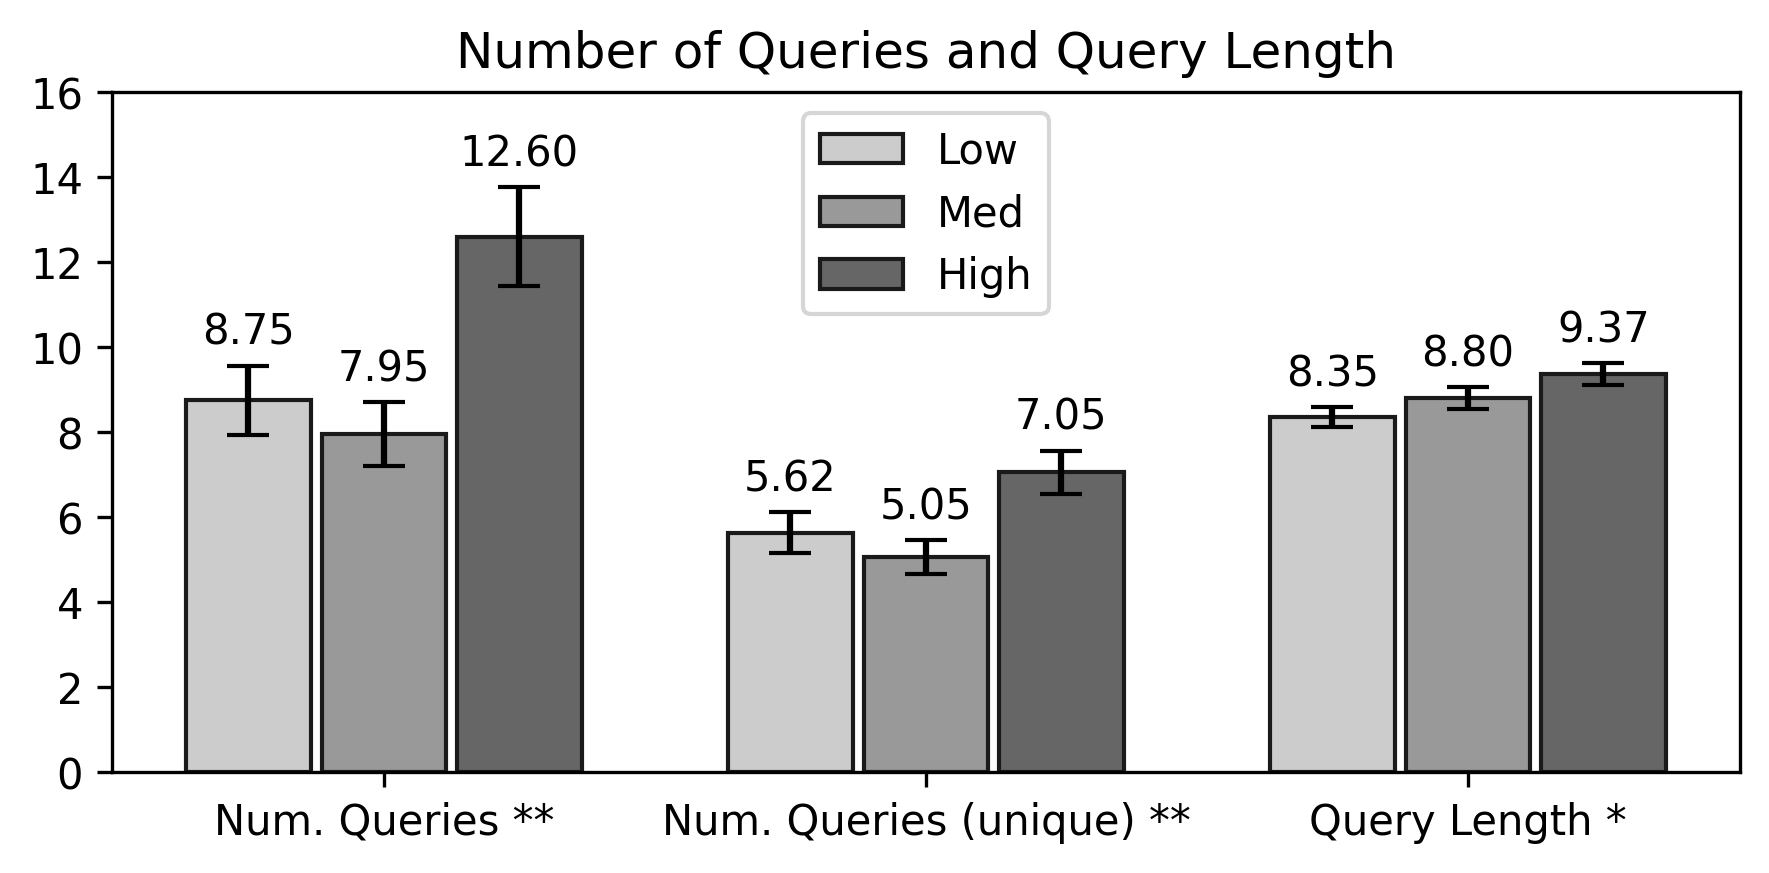

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

labels = [ 'Num. Queries **', 'Num. Queries (unique) **', 'Query Length *' ]

means_low = [ 
                np.mean( getDVvalues( data, qrels, tests, numq, 'Low', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, numq_unique, 'Low', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, qlen, 'Low', ['1','2'] ) )
            ]
means_med = [ 
                np.mean( getDVvalues( data, qrels, tests, numq, 'Med', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, numq_unique, 'Med', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, qlen, 'Med', ['1','2'] ) )
            ]
means_high = [ 
                np.mean( getDVvalues( data, qrels, tests, numq, 'High', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, numq_unique, 'High', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, qlen, 'High', ['1','2'] ) )
            ]

sem_low =   [ 
                stats.sem( getDVvalues( data, qrels, tests, numq, 'Low', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, numq_unique, 'Low', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, qlen, 'Low', ['1','2'] ) )
            ]
sem_med =   [ 
                stats.sem( getDVvalues( data, qrels, tests, numq, 'Med', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, numq_unique, 'Med', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, qlen, 'Med', ['1','2'] ) )
            ]
sem_high =  [ 
                stats.sem( getDVvalues( data, qrels, tests, numq, 'High', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, numq_unique, 'High', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, qlen, 'High', ['1','2'] ) )
            ]

x = np.arange( len(labels) )

fig, ax = plt.subplots( 1, 1, figsize=(7,3), dpi=300 )

rects1 = ax.bar( x - 0.25, means_low, 0.23, label='Low', color=(0.8, 0.8, 0.8), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_low )
rects2 = ax.bar( x       , means_med, 0.23, label='Med', color=(0.6, 0.6, 0.6), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_med )
rects3 = ax.bar( x + 0.25, means_high, 0.23, label='High', color=(0.4, 0.4, 0.4), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_high )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,16])
# ax.set_ylabel('Scores')
ax.set_title('Number of Queries and Query Length')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center')

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

plt.savefig( os.path.join(workdir, 'query.png'), dpi=300 )
plt.show()

### Query Similarity

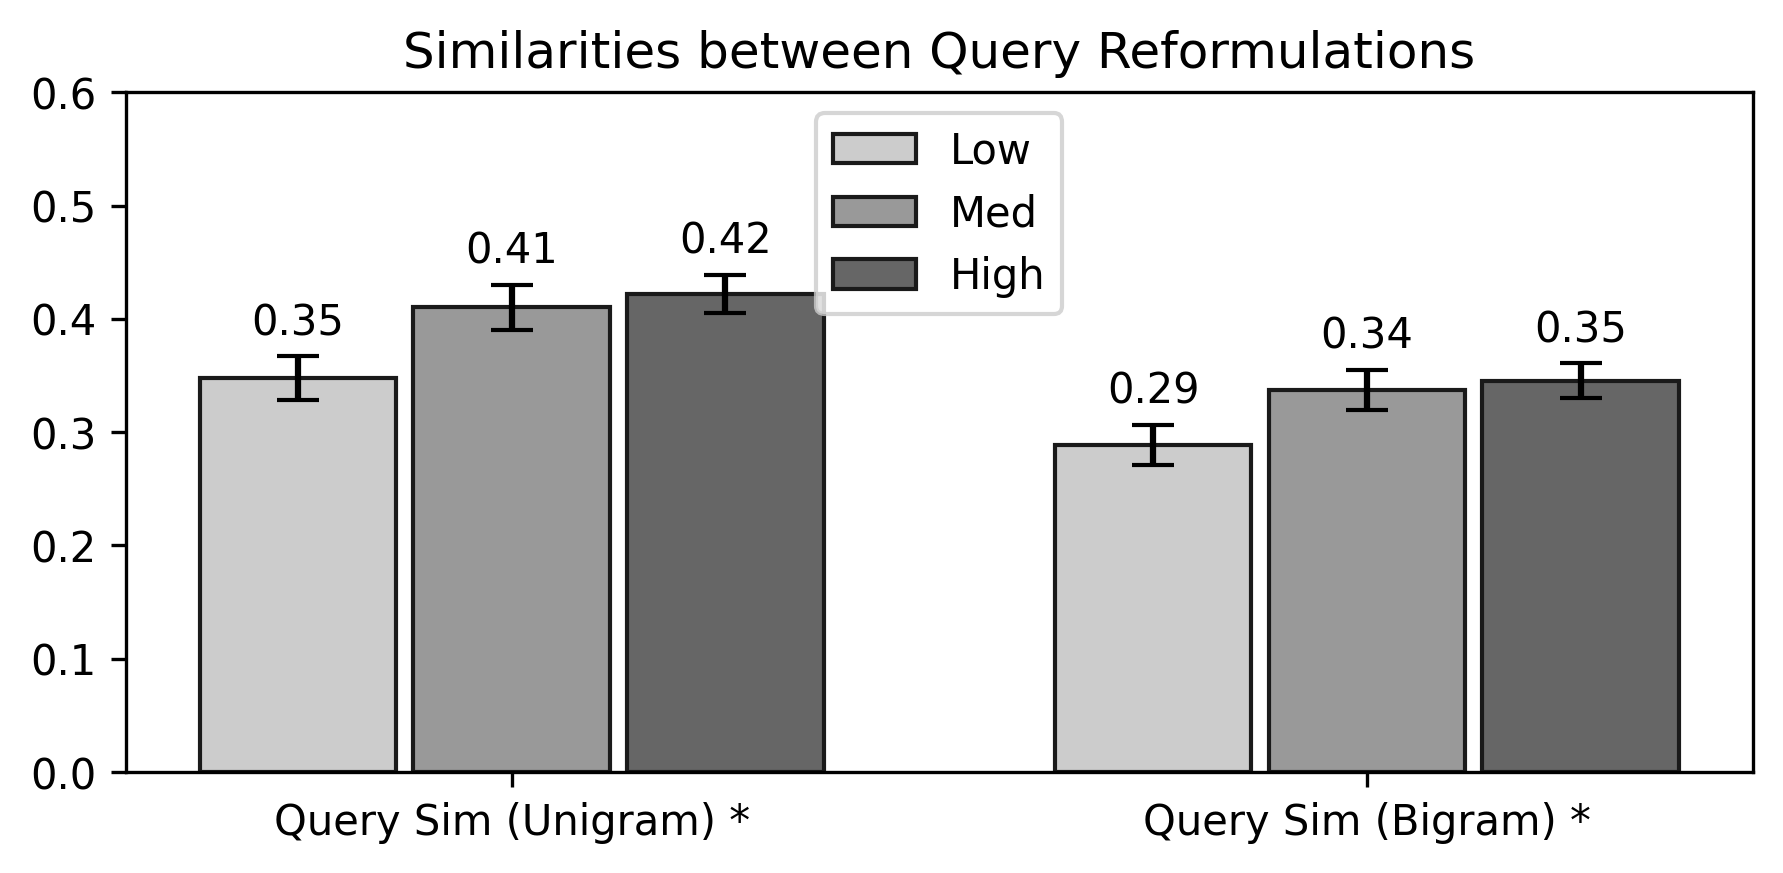

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

labels = [ 'Query Sim (Unigram) *', 'Query Sim (Bigram) *' ]

means_low = [ 
                np.mean( getDVvalues( data, qrels, tests, qsim_unigram, 'Low', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, qsim_bigram, 'Low', ['1','2'] ) )
            ]
means_med = [ 
                np.mean( getDVvalues( data, qrels, tests, qsim_unigram, 'Med', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, qsim_bigram, 'Med', ['1','2'] ) )
            ]
means_high = [ 
                np.mean( getDVvalues( data, qrels, tests, qsim_unigram, 'High', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, qsim_bigram, 'High', ['1','2'] ) )
            ]

sem_low =   [ 
                stats.sem( getDVvalues( data, qrels, tests, qsim_unigram, 'Low', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, qsim_bigram, 'Low', ['1','2'] ) )
            ]
sem_med =   [ 
                stats.sem( getDVvalues( data, qrels, tests, qsim_unigram, 'Med', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, qsim_bigram, 'Med', ['1','2'] ) )
            ]
sem_high =  [ 
                stats.sem( getDVvalues( data, qrels, tests, qsim_unigram, 'High', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, qsim_bigram, 'High', ['1','2'] ) )
            ]

x = np.arange( len(labels) )

fig, ax = plt.subplots( 1, 1, figsize=(7,3), dpi=300 )

rects1 = ax.bar( x - 0.25, means_low, 0.23, label='Low', color=(0.8, 0.8, 0.8), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_low )
rects2 = ax.bar( x       , means_med, 0.23, label='Med', color=(0.6, 0.6, 0.6), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_med )
rects3 = ax.bar( x + 0.25, means_high, 0.23, label='High', color=(0.4, 0.4, 0.4), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_high )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,0.6])
# ax.set_ylabel('Scores')
ax.set_title('Similarities between Query Reformulations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center')

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

plt.savefig( os.path.join(workdir, 'qsim.png'), dpi=300 )
plt.show()

### Click

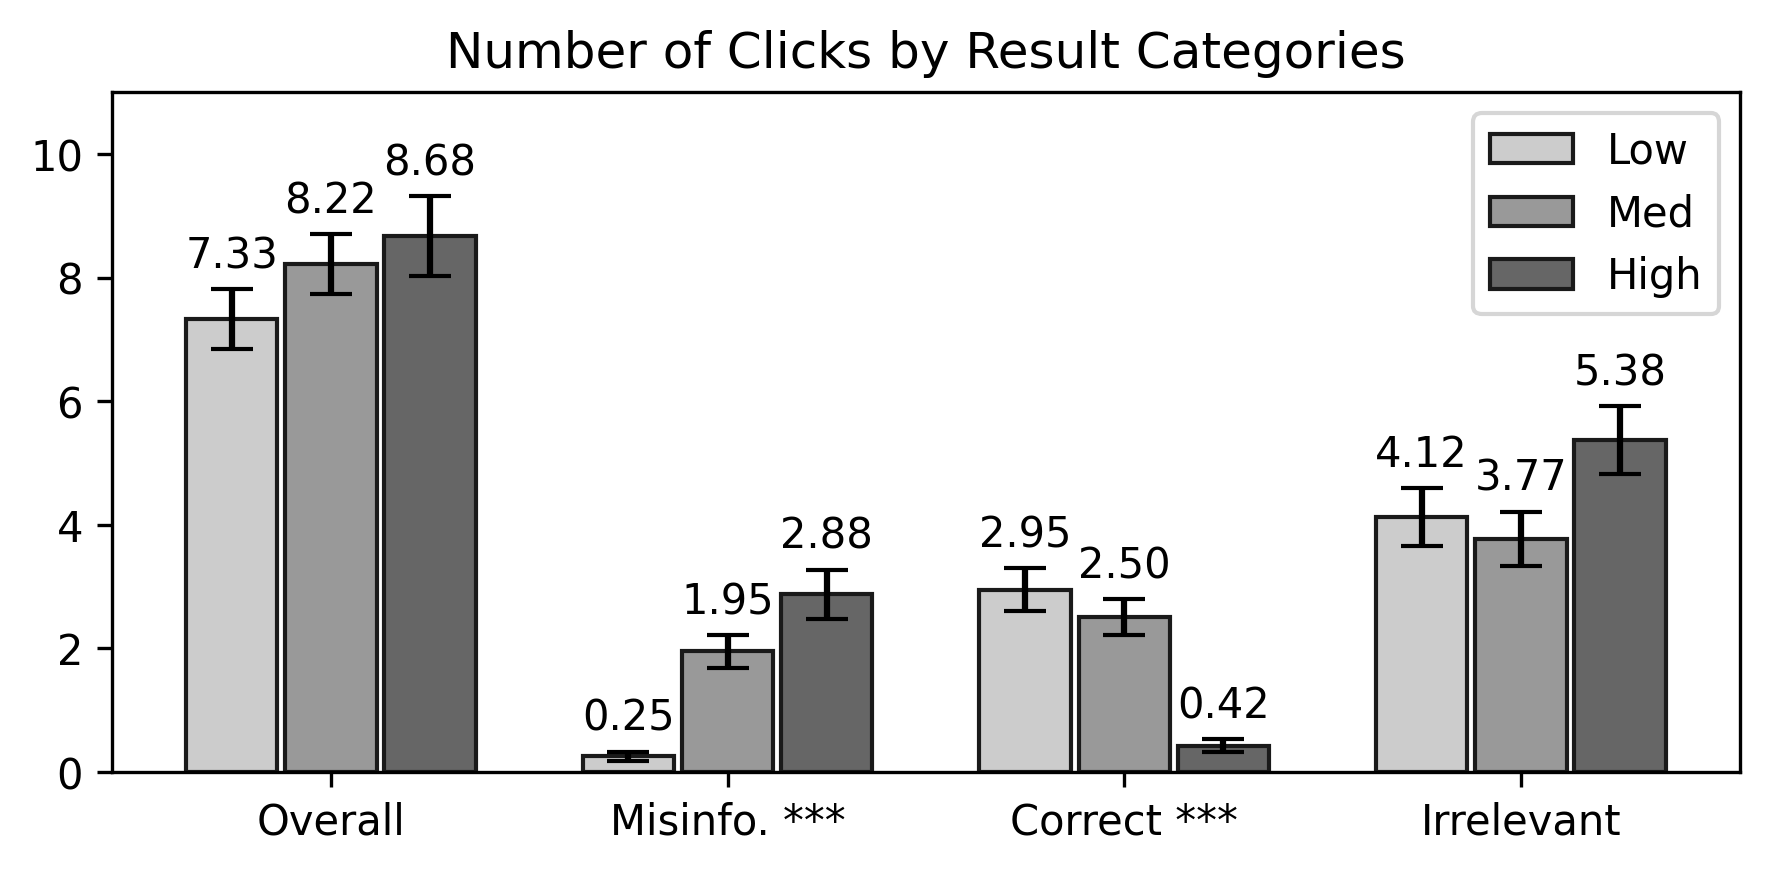

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

labels = [ 'Overall', 'Misinfo. ***', 'Correct ***', 'Irrelevant' ]

means_low = [ 
                np.mean( getDVvalues( data, qrels, tests, numclicks, 'Low', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, numclicks_misinfo, 'Low', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, numclicks_correct, 'Low', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, numclicks_nrel, 'Low', ['1','2'] ) )
            ]
means_med = [ 
                np.mean( getDVvalues( data, qrels, tests, numclicks, 'Med', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, numclicks_misinfo, 'Med', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, numclicks_correct, 'Med', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, numclicks_nrel, 'Med', ['1','2'] ) )
            ]
means_high = [ 
                np.mean( getDVvalues( data, qrels, tests, numclicks, 'High', ['1','2'] ) ), 
                np.mean( getDVvalues( data, qrels, tests, numclicks_misinfo, 'High', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, numclicks_correct, 'High', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, numclicks_nrel, 'High', ['1','2'] ) )
            ]

sem_low =   [ 
                stats.sem( getDVvalues( data, qrels, tests, numclicks, 'Low', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, numclicks_misinfo, 'Low', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, numclicks_correct, 'Low', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, numclicks_nrel, 'Low', ['1','2'] ) )
            ]
sem_med =   [ 
                stats.sem( getDVvalues( data, qrels, tests, numclicks, 'Med', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, numclicks_misinfo, 'Med', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, numclicks_correct, 'Med', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, numclicks_nrel, 'Med', ['1','2'] ) )
            ]
sem_high =  [ 
                stats.sem( getDVvalues( data, qrels, tests, numclicks, 'High', ['1','2'] ) ), 
                stats.sem( getDVvalues( data, qrels, tests, numclicks_misinfo, 'High', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, numclicks_correct, 'High', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, numclicks_nrel, 'High', ['1','2'] ) )
            ]

x = np.arange( len(labels) )

fig, ax = plt.subplots( 1, 1, figsize=(7,3), dpi=300 )

rects1 = ax.bar( x - 0.25, means_low, 0.23, label='Low', color=(0.8, 0.8, 0.8), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_low )
rects2 = ax.bar( x       , means_med, 0.23, label='Med', color=(0.6, 0.6, 0.6), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_med )
rects3 = ax.bar( x + 0.25, means_high, 0.23, label='High', color=(0.4, 0.4, 0.4), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_high )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,11])
# ax.set_ylabel('Scores')
ax.set_title('Number of Clicks by Result Categories')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

plt.savefig( os.path.join(workdir, 'numclicks.png'), dpi=300 )
plt.show()

### Click Ratio

/tmp/ipykernel_8079/114190323.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['%d%%'%x for x in plt.gca().get_yticks()])


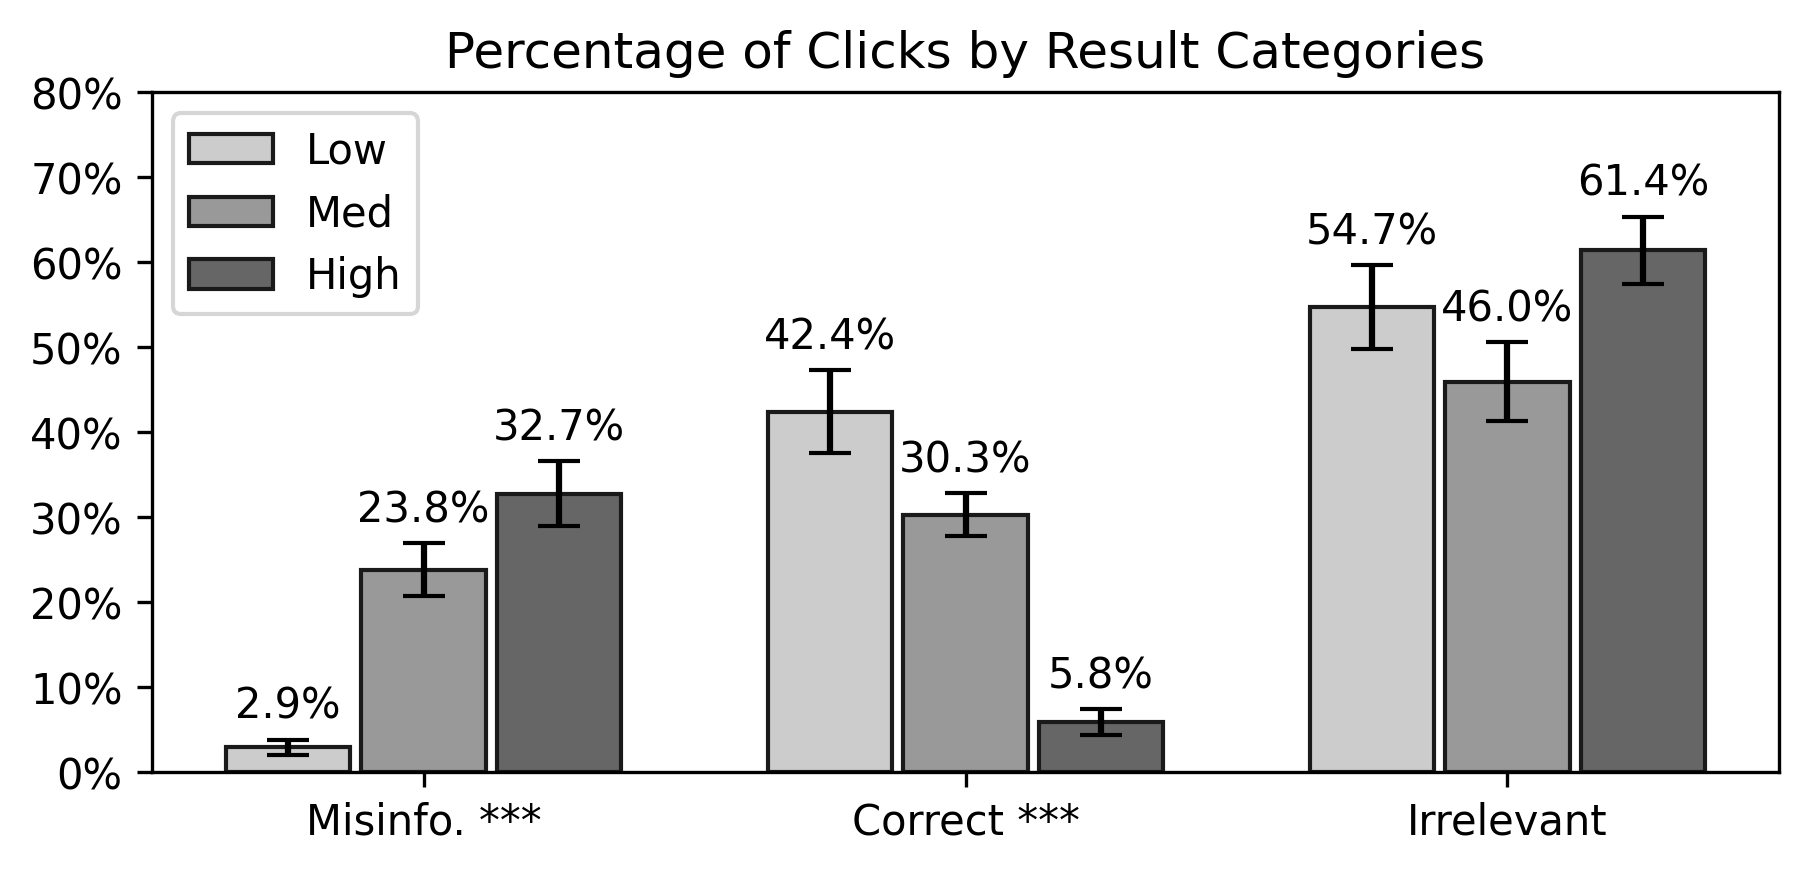

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

labels = [ 'Misinfo. ***', 'Correct ***', 'Irrelevant' ]

means_low = [ 
                100*np.mean( getDVvalues( data, qrels, tests, ratioclicks_misinfo, 'Low', ['1','2'] ) ), 
                100*np.mean( getDVvalues( data, qrels, tests, ratioclicks_correct, 'Low', ['1','2'] ) ),
                100*np.mean( getDVvalues( data, qrels, tests, ratioclicks_nrel, 'Low', ['1','2'] ) )
            ]
means_med = [ 
                100*np.mean( getDVvalues( data, qrels, tests, ratioclicks_misinfo, 'Med', ['1','2'] ) ), 
                100*np.mean( getDVvalues( data, qrels, tests, ratioclicks_correct, 'Med', ['1','2'] ) ),
                100*np.mean( getDVvalues( data, qrels, tests, ratioclicks_nrel, 'Med', ['1','2'] ) )
            ]
means_high = [ 
                100*np.mean( getDVvalues( data, qrels, tests, ratioclicks_misinfo, 'High', ['1','2'] ) ), 
                100*np.mean( getDVvalues( data, qrels, tests, ratioclicks_correct, 'High', ['1','2'] ) ),
                100*np.mean( getDVvalues( data, qrels, tests, ratioclicks_nrel, 'High', ['1','2'] ) )
            ]

sem_low =   [ 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioclicks_misinfo, 'Low', ['1','2'] ) ), 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioclicks_correct, 'Low', ['1','2'] ) ),
                100*stats.sem( getDVvalues( data, qrels, tests, ratioclicks_nrel, 'Low', ['1','2'] ) )
            ]
sem_med =   [ 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioclicks_misinfo, 'Med', ['1','2'] ) ), 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioclicks_correct, 'Med', ['1','2'] ) ),
                100*stats.sem( getDVvalues( data, qrels, tests, ratioclicks_nrel, 'Med', ['1','2'] ) )
            ]
sem_high =  [ 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioclicks_misinfo, 'High', ['1','2'] ) ), 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioclicks_correct, 'High', ['1','2'] ) ),
                100*stats.sem( getDVvalues( data, qrels, tests, ratioclicks_nrel, 'High', ['1','2'] ) )
            ]

x = np.arange( len(labels) )

fig, ax = plt.subplots( 1, 1, figsize=(7,3), dpi=300 )

rects1 = ax.bar( x - 0.25, means_low, 0.23, label='Low', color=(0.8, 0.8, 0.8), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_low )
rects2 = ax.bar( x       , means_med, 0.23, label='Med', color=(0.6, 0.6, 0.6), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_med )
rects3 = ax.bar( x + 0.25, means_high, 0.23, label='High', color=(0.4, 0.4, 0.4), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_high )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,80])
plt.gca().set_yticklabels(['%d%%'%x for x in plt.gca().get_yticks()])
ax.set_title('Percentage of Clicks by Result Categories')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=3, fmt='%.1f%%')
ax.bar_label(rects2, padding=3, fmt='%.1f%%')
ax.bar_label(rects3, padding=3, fmt='%.1f%%')

plt.savefig( os.path.join(workdir, 'ratioclicks.png'), dpi=300 )
plt.show()

### Displayed Results Ratio

/tmp/ipykernel_8079/2810928405.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['%d%%'%x for x in plt.gca().get_yticks()])


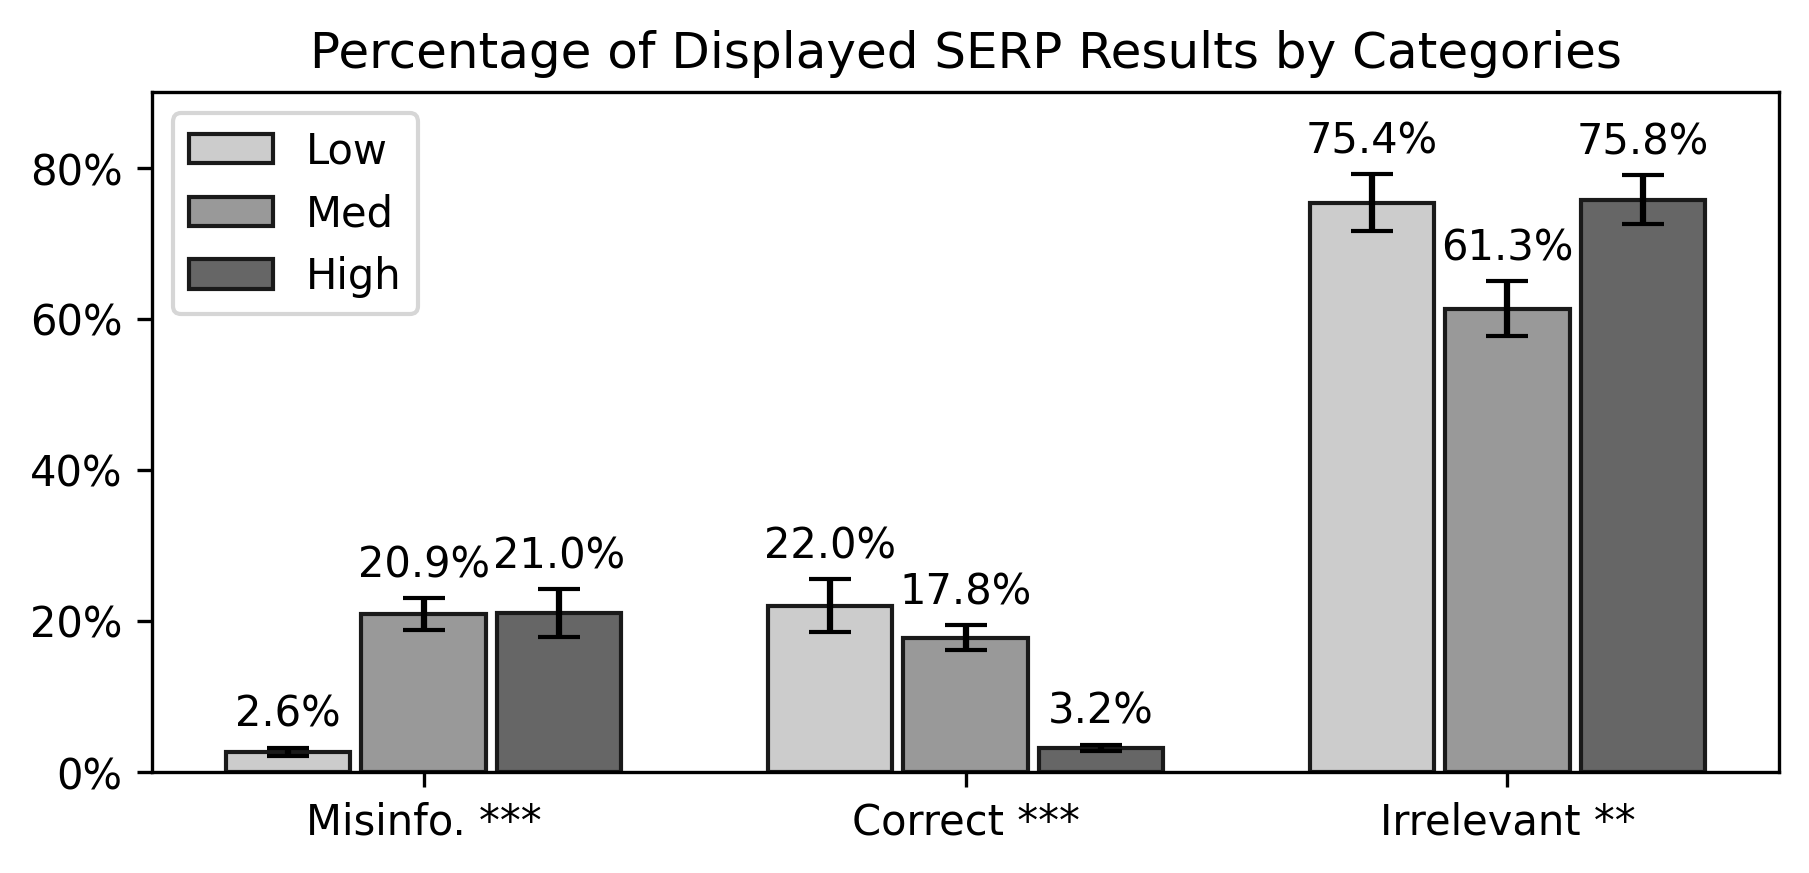

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

labels = [ 'Misinfo. ***', 'Correct ***', 'Irrelevant **' ]

means_low = [ 
                100*np.mean( getDVvalues( data, qrels, tests, ratioresults_misinfo, 'Low', ['1','2'] ) ), 
                100*np.mean( getDVvalues( data, qrels, tests, ratioresults_correct, 'Low', ['1','2'] ) ),
                100*np.mean( getDVvalues( data, qrels, tests, ratioresults_nrel, 'Low', ['1','2'] ) )
            ]
means_med = [ 
                100*np.mean( getDVvalues( data, qrels, tests, ratioresults_misinfo, 'Med', ['1','2'] ) ), 
                100*np.mean( getDVvalues( data, qrels, tests, ratioresults_correct, 'Med', ['1','2'] ) ),
                100*np.mean( getDVvalues( data, qrels, tests, ratioresults_nrel, 'Med', ['1','2'] ) )
            ]
means_high = [ 
                100*np.mean( getDVvalues( data, qrels, tests, ratioresults_misinfo, 'High', ['1','2'] ) ), 
                100*np.mean( getDVvalues( data, qrels, tests, ratioresults_correct, 'High', ['1','2'] ) ),
                100*np.mean( getDVvalues( data, qrels, tests, ratioresults_nrel, 'High', ['1','2'] ) )
            ]

sem_low =   [ 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioresults_misinfo, 'Low', ['1','2'] ) ), 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioresults_correct, 'Low', ['1','2'] ) ),
                100*stats.sem( getDVvalues( data, qrels, tests, ratioresults_nrel, 'Low', ['1','2'] ) )
            ]
sem_med =   [ 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioresults_misinfo, 'Med', ['1','2'] ) ), 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioresults_correct, 'Med', ['1','2'] ) ),
                100*stats.sem( getDVvalues( data, qrels, tests, ratioresults_nrel, 'Med', ['1','2'] ) )
            ]
sem_high =  [ 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioresults_misinfo, 'High', ['1','2'] ) ), 
                100*stats.sem( getDVvalues( data, qrels, tests, ratioresults_correct, 'High', ['1','2'] ) ),
                100*stats.sem( getDVvalues( data, qrels, tests, ratioresults_nrel, 'High', ['1','2'] ) )
            ]

x = np.arange( len(labels) )

fig, ax = plt.subplots( 1, 1, figsize=(7,3), dpi=300 )

rects1 = ax.bar( x - 0.25, means_low, 0.23, label='Low', color=(0.8, 0.8, 0.8), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_low )
rects2 = ax.bar( x       , means_med, 0.23, label='Med', color=(0.6, 0.6, 0.6), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_med )
rects3 = ax.bar( x + 0.25, means_high, 0.23, label='High', color=(0.4, 0.4, 0.4), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_high )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,90])
plt.gca().set_yticklabels(['%d%%'%x for x in plt.gca().get_yticks()])
ax.set_title('Percentage of Displayed SERP Results by Categories')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

ax.bar_label(rects1, padding=3, fmt='%.1f%%')
ax.bar_label(rects2, padding=3, fmt='%.1f%%')
ax.bar_label(rects3, padding=3, fmt='%.1f%%')

plt.savefig( os.path.join(workdir, 'ratioresults.png'), dpi=300 )
plt.show()

### Factual Questions

/tmp/ipykernel_8079/652267936.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['%d%%'%x for x in plt.gca().get_yticks()])


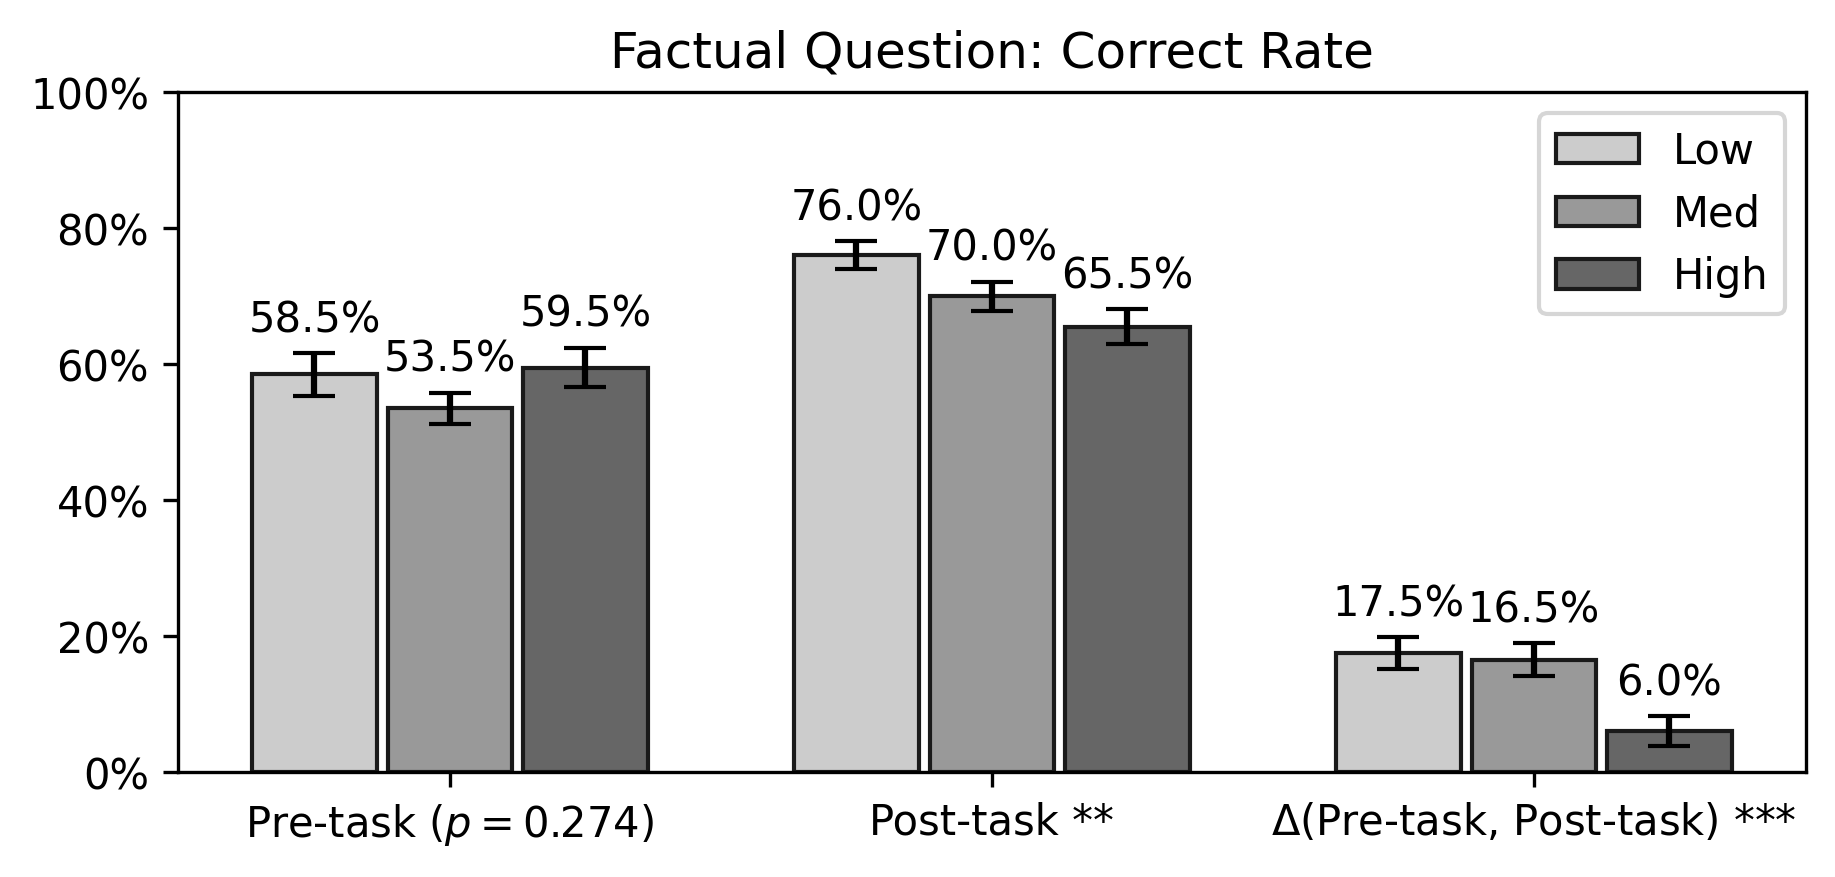

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

labels = [ 'Pre-task ($p=0.274$)', 'Post-task **', '$\Delta$(Pre-task, Post-task) ***' ]

means_low = [
                100 * np.mean( getDVvalues( data, qrels, tests, pre_correctness, 'Low', ['1','2'] ) ),
                100 * np.mean( getDVvalues( data, qrels, tests, post_correctness, 'Low', ['1','2'] ) ),
                100 * np.mean( getDVvalues( data, qrels, tests, diff_correctness, 'Low', ['1','2'] ) )
            ]
means_med = [
                100 * np.mean( getDVvalues( data, qrels, tests, pre_correctness, 'Med', ['1','2'] ) ),
                100 * np.mean( getDVvalues( data, qrels, tests, post_correctness, 'Med', ['1','2'] ) ),
                100 * np.mean( getDVvalues( data, qrels, tests, diff_correctness, 'Med', ['1','2'] ) )
            ]
means_high = [
                100 * np.mean( getDVvalues( data, qrels, tests, pre_correctness, 'High', ['1','2'] ) ),
                100 * np.mean( getDVvalues( data, qrels, tests, post_correctness, 'High', ['1','2'] ) ),
                100 * np.mean( getDVvalues( data, qrels, tests, diff_correctness, 'High', ['1','2'] ) )
            ]

sem_low =   [
                100 * stats.sem( getDVvalues( data, qrels, tests, pre_correctness, 'Low', ['1','2'] ) ),
                100 * stats.sem( getDVvalues( data, qrels, tests, post_correctness, 'Low', ['1','2'] ) ),
                100 * stats.sem( getDVvalues( data, qrels, tests, diff_correctness, 'Low', ['1','2'] ) )
            ]
sem_med =   [
                100 * stats.sem( getDVvalues( data, qrels, tests, pre_correctness, 'Med', ['1','2'] ) ),
                100 * stats.sem( getDVvalues( data, qrels, tests, post_correctness, 'Med', ['1','2'] ) ),
                100 * stats.sem( getDVvalues( data, qrels, tests, diff_correctness, 'Med', ['1','2'] ) )
            ]
sem_high =  [
                100 * stats.sem( getDVvalues( data, qrels, tests, pre_correctness, 'High', ['1','2'] ) ),
                100 * stats.sem( getDVvalues( data, qrels, tests, post_correctness, 'High', ['1','2'] ) ),
                100 * stats.sem( getDVvalues( data, qrels, tests, diff_correctness, 'High', ['1','2'] ) )
            ]

x = np.arange( len(labels) )

fig, ax = plt.subplots( 1, 1, figsize=(7,3), dpi=300 )

rects1 = ax.bar( x - 0.25, means_low, 0.23, label='Low', color=(0.8, 0.8, 0.8), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_low )
rects2 = ax.bar( x       , means_med, 0.23, label='Med', color=(0.6, 0.6, 0.6), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_med )
rects3 = ax.bar( x + 0.25, means_high, 0.23, label='High', color=(0.4, 0.4, 0.4), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_high )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,100])
plt.gca().set_yticklabels(['%d%%'%x for x in plt.gca().get_yticks()])
ax.set_title('Factual Question: Correct Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=3, fmt='%.1f%%')
ax.bar_label(rects2, padding=3, fmt='%.1f%%')
ax.bar_label(rects3, padding=3, fmt='%.1f%%')

plt.savefig( os.path.join(workdir, 'factq_correct.png'), dpi=300 )
plt.show()

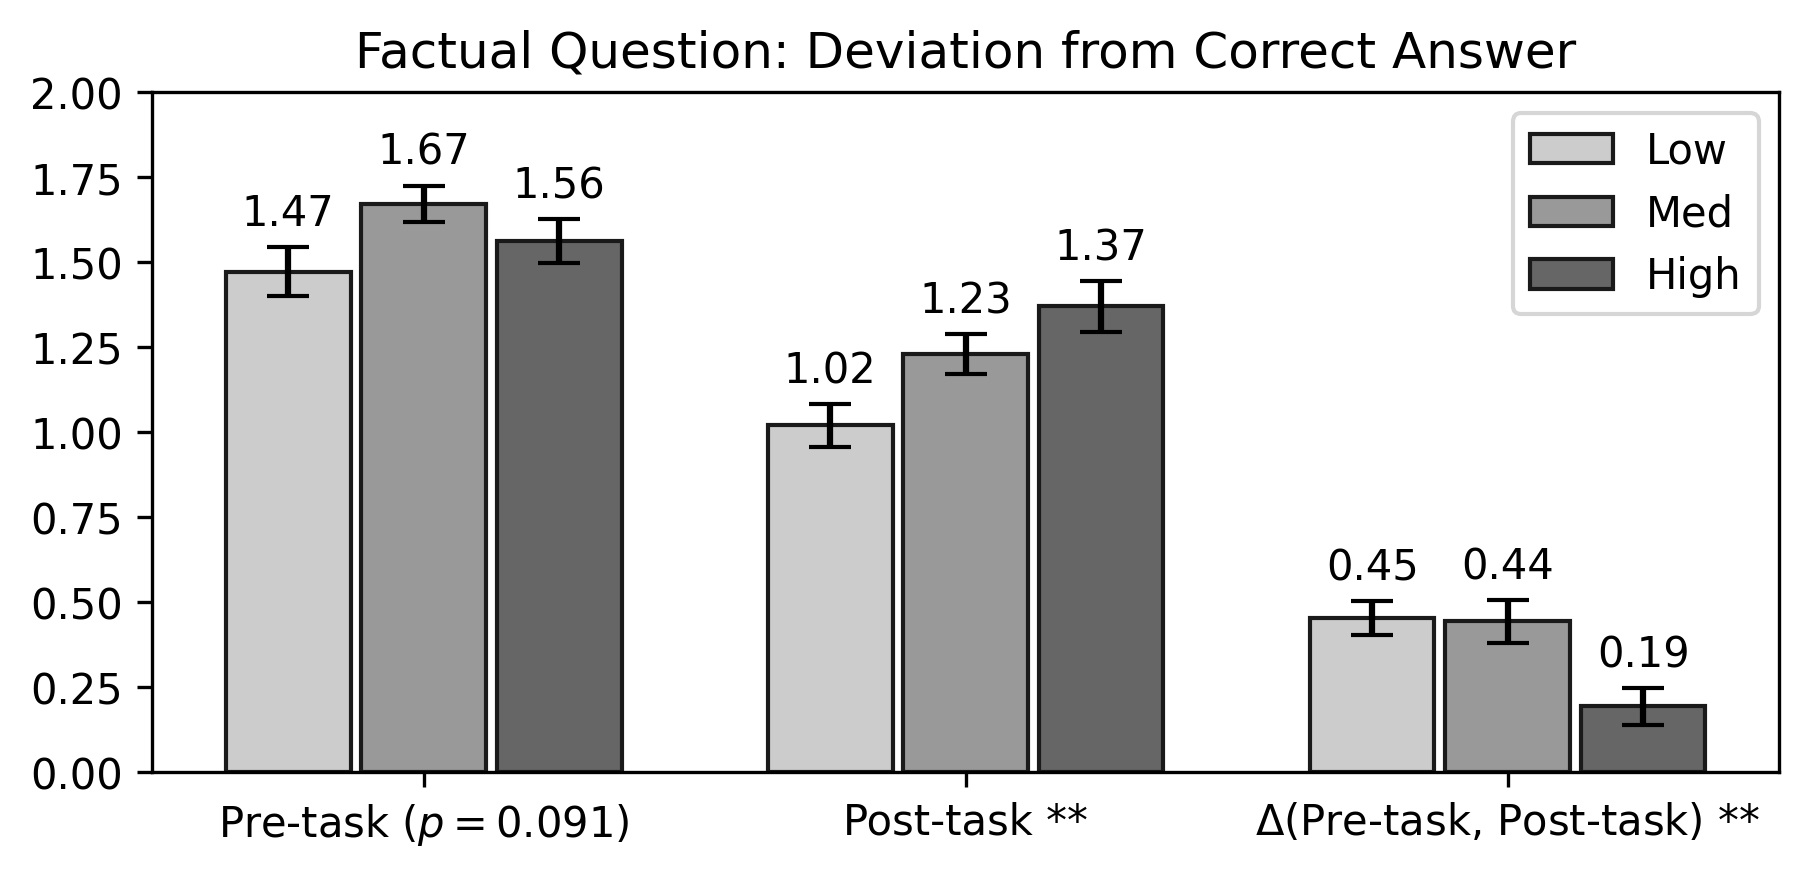

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

labels = [ 'Pre-task ($p=0.091$)', 'Post-task **', '$\Delta$(Pre-task, Post-task) **' ]

means_low = [
                np.mean( getDVvalues( data, qrels, tests, pre_deviation, 'Low', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, post_deviation, 'Low', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, diff_deviation, 'Low', ['1','2'] ) )
            ]
means_med = [
                np.mean( getDVvalues( data, qrels, tests, pre_deviation, 'Med', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, post_deviation, 'Med', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, diff_deviation, 'Med', ['1','2'] ) )
            ]
means_high = [
                np.mean( getDVvalues( data, qrels, tests, pre_deviation, 'High', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, post_deviation, 'High', ['1','2'] ) ),
                np.mean( getDVvalues( data, qrels, tests, diff_deviation, 'High', ['1','2'] ) )
            ]

sem_low =   [
                stats.sem( getDVvalues( data, qrels, tests, pre_deviation, 'Low', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, post_deviation, 'Low', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, diff_deviation, 'Low', ['1','2'] ) )
            ]
sem_med =   [
                stats.sem( getDVvalues( data, qrels, tests, pre_deviation, 'Med', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, post_deviation, 'Med', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, diff_deviation, 'Med', ['1','2'] ) )
            ]
sem_high =  [
                stats.sem( getDVvalues( data, qrels, tests, pre_deviation, 'High', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, post_deviation, 'High', ['1','2'] ) ),
                stats.sem( getDVvalues( data, qrels, tests, diff_deviation, 'High', ['1','2'] ) )
            ]

x = np.arange( len(labels) )

fig, ax = plt.subplots( 1, 1, figsize=(7,3), dpi=300 )

rects1 = ax.bar( x - 0.25, means_low, 0.23, label='Low', color=(0.8, 0.8, 0.8), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_low )
rects2 = ax.bar( x       , means_med, 0.23, label='Med', color=(0.6, 0.6, 0.6), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_med )
rects3 = ax.bar( x + 0.25, means_high, 0.23, label='High', color=(0.4, 0.4, 0.4), edgecolor=(0.1,0.1,0.1), capsize=5, yerr=sem_high )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,2])
# ax.set_ylabel('Scores')
ax.set_title('Factual Question: Deviation from Correct Answer')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

plt.savefig( os.path.join(workdir, 'factq_dev.png'), dpi=300 )
plt.show()